# 20190108: Pulling out synonymous WT mutants

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
my_store = pd.HDFStore('2017.07.24_Radicicol_exp.h5')
myStoreKeys = my_store.keys()

variantScores = my_store.select('/main/variants/scores')

In [3]:
# Keep only rows with WT sequences 
idx = variantScores.index.tolist()
idx = ['(p.=)' in name for name in idx]

variantScores = variantScores[idx]

idx = variantScores.index.tolist()
wtMuts = [name.count('(p.=)') for name in idx]
otherMuts = [name.count('(p.') for name in idx]
wtMutsOnly = []
for idMuts, muts in zip(wtMuts, otherMuts):
    wtMutsOnly.append(idMuts == muts)
    
variantScores = variantScores[wtMutsOnly]

In [4]:
# Remove nans from score arrays
varRad = variantScores.loc[:, ('Radicicol', 'score')].values
varRad = varRad[~np.isnan(varRad)]

varZero = variantScores.loc[:, ('Zero', 'score')].values
varZero = varZero[~np.isnan(varZero)]

/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


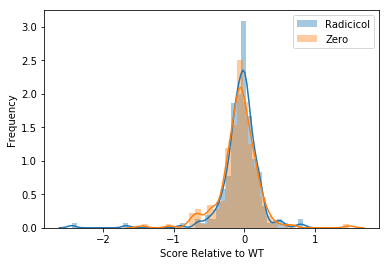

In [5]:
# Plot distributions
sns.distplot(varRad, label = 'Radicicol')
sns.distplot(varZero, label = 'Zero')
plt.xlabel('Score Relative to WT')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 20190109: Function for pulling out synonymous WT mutants

In [6]:
def getSynMuts(df):
    idx = df.index.tolist()
    idx = ['(p.=)' in name for name in idx]
    df = df[idx]
    idx = df.index.tolist()
    wtMuts = [name.count('(p.=)') for name in idx]
    otherMuts = [name.count('(p.') for name in idx]
    wtMutsOnly = []
    for idMuts, muts in zip(wtMuts, otherMuts):
        wtMutsOnly.append(idMuts == muts)
    return(df[wtMutsOnly])

In [7]:
def getSynMuts2(df):
    """
    Takes a DataFrame with codon and protein mutations in as the index and returns a DataFrame 
    with only the wild type synonymous mutants, mutants that have protein sequence identity to 
    that of the wild type.
    """
    idx = df.index.tolist()
    wtMuts = [name.count('(p.=)') for name in idx]
    otherMuts = [name.count('(p.') for name in idx]
    wtMutsOnly = []
    for idMuts, muts in zip(wtMuts, otherMuts):
        wtMutsOnly.append(idMuts == muts)
    return(df[wtMutsOnly])

# Getting standard deviation to threshold variants

In [8]:
# Define standard deviations for radicicol and control treatments for synonymous mutants and load synonymous data
sdRad = np.std(varRad)    # 0.2926579180309401
sdZero = np.std(varZero)  # 0.28323869489237435

srcBothReps = pd.read_csv('main_synonymous_both_reps.csv', index_col = 0)

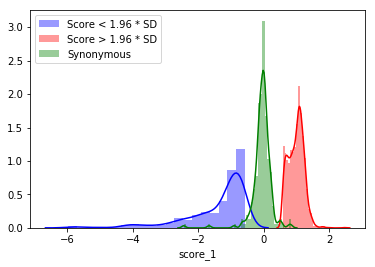

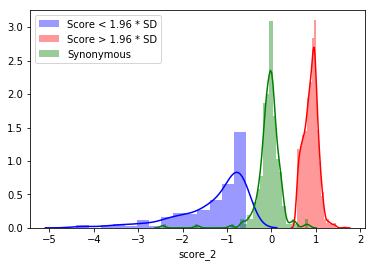

In [9]:
i = 1
thresh = 1.96 * sdRad
for score in ['score_1', 'score_2']:
    plt.figure(i)
    scores = srcBothReps[score].dropna()
    negScore = scores[(scores < -thresh)]
    posScore = scores[(scores > thresh)]
    sns.distplot(negScore, color = 'b', label = "Score < 1.96 * SD")
    sns.distplot(posScore, color = 'r', label = 'Score > 1.96 * SD')
    sns.distplot(varRad, color = 'g', label = 'Synonymous')
    plt.legend()
    plt.ylim(0, 3.25)
    plt.show()
    i += 1

# Using main scores and getting summary statistics

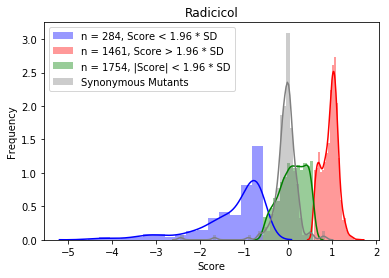

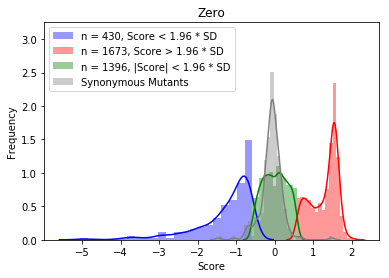

In [10]:
pointMuts = my_store.select('/main/synonymous/scores')[2:]    # Dropped _sy and _wt (what is _sy?)
idx = [',' not in name for name in pointMuts.index.tolist()] 
pointMuts = pointMuts[idx]
pointMuts = pointMuts[pointMuts['Radicicol', 'score'].notna() & pointMuts['Zero', 'score'].notna()]
i = 1
for treatment, syn in zip(['Radicicol', 'Zero'], [varRad, varZero]):
    plt.figure(i)
    scores = pointMuts[treatment, 'score'].dropna()
    negScore = scores[(scores < -thresh)]
    posScore = scores[(scores > thresh)]
    wtScore = scores[((scores > -thresh) & (scores < thresh))]
    sns.distplot(negScore, color = 'b', label = ('n = %d, Score < 1.96 * SD' %len(negScore)))
    sns.distplot(posScore, color = 'r', label = ('n = %d, Score > 1.96 * SD' %len(posScore)))
    sns.distplot(wtScore, color = 'g', label = ('n = %d, |Score| < 1.96 * SD' %len(wtScore)))
    sns.distplot(syn, color = 'grey', label = 'Synonymous Mutants')
    plt.legend()
    plt.ylim(0, 3.25)
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.title(treatment)
    plt.show()
    i += 1

# 20190110: Getting full distribution shapes and figuring out radicicol sensitivity metric

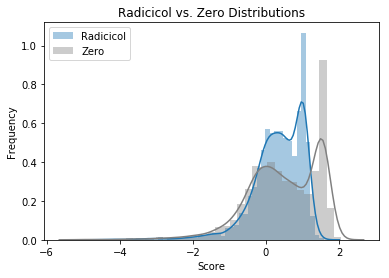

In [14]:
# Distribution of radicicol and zero treatments for point mutants
sns.distplot(pointMuts['Radicicol', 'score'], label = 'Radicicol')
sns.distplot(pointMuts['Zero', 'score'], label = 'Zero', color = 'gray')
plt.legend()
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Radicicol vs. Zero Distributions')
plt.show()

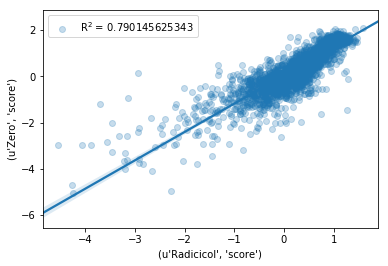

In [39]:
# Probing for radicicol sensitivity metric
radPointMuts = pointMuts['Radicicol', 'score']
zerPointMuts = pointMuts['Zero', 'score']
r = np.corrcoef(radPointMuts, zerPointMuts)
rsq = r[0,1]**2
sns.regplot(radPointMuts, zerPointMuts, scatter_kws = {'alpha':0.25}, label = "R$^2$ = "+ str(rsq))
plt.legend()
plt.show()

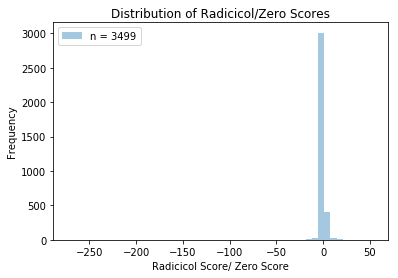

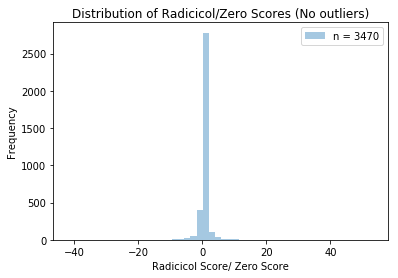

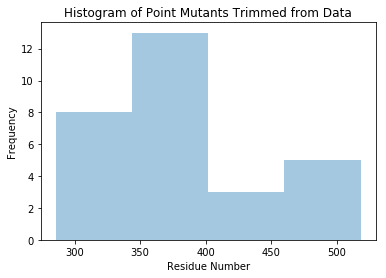

In [99]:
# Looking at the distribution of the ratio Radicicol/Zero
ratios = radPointMuts / zerPointMuts
sns.distplot(ratios, kde = False, label = 'n = %d' %len(ratios))
plt.xlabel('Radicicol Score/ Zero Score')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Radicicol/Zero Scores')
plt.show()

thresh = np.std(ratios) * 1.96

lowRatios = ratios[ratios < -thresh]
highRatios = ratios[ratios > thresh]

ratioTrim = ratios.drop(lowRatios.index.tolist())
ratioTrim = ratioTrim.drop(highRatios.index.tolist())
sns.distplot(ratioNoLow, kde = False, label = 'n = %d' %len(ratioTrim))
plt.legend()
plt.xlabel('Radicicol Score/ Zero Score')
plt.ylabel('Frequency')
plt.title('Distribution of Radicicol/Zero Scores (No outliers)')
plt.show()

# Which mutations were trimmed from the data?
trimmedRatioMuts = set(ratios.index.tolist()) - set(ratioTrim.index.tolist())
sns.distplot([int(name[5:8]) for name in trimmedRatioMuts], kde = False)
plt.xlabel('Residue Number')
plt.ylabel('Frequency')
plt.title('Histogram of Point Mutants Trimmed from Data')
plt.show()

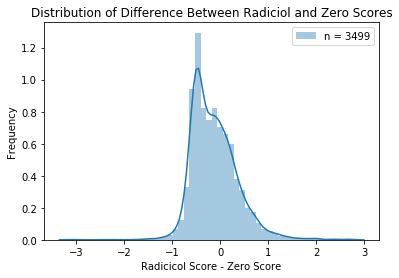

In [104]:
# Looking at differences between radicicol and zero scores
diffs = radPointMuts - zerPointMuts
sns.distplot(diffs, label = 'n = %d' %len(diffs))
plt.legend()
plt.title('Distribution of Difference Between Radiciol and Zero Scores')
plt.xlabel('Radicicol Score - Zero Score')
plt.ylabel('Frequency')
plt.show()

# 20191111: Radicicol sensitivity metric

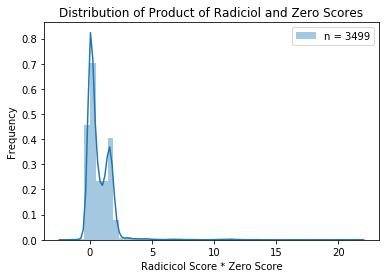

In [108]:
# Looking at product of radicicol and zero scores
prods = radPointMuts * zerPointMuts
sns.distplot(prods, label = 'n = %d' %len(diffs))
plt.legend()
plt.title('Distribution of Product of Radiciol and Zero Scores')
plt.xlabel('Radicicol Score * Zero Score')
plt.ylabel('Frequency')
plt.show()

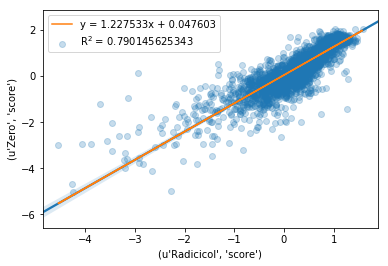

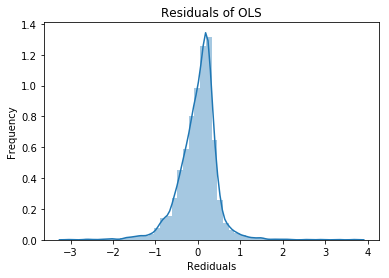

In [163]:
# Looking at residuals as a weighting metric
sns.regplot(radPointMuts, zerPointMuts, scatter_kws = {'alpha':0.25}, label = "R$^2$ = "+ str(rsq))
[m, b] = np.polyfit(radPointMuts, zerPointMuts, 1)
zerPointMutsHat = (b + m * radPointMuts)
plt.plot(radPointMuts, zerPointMutsHat, label = 'y = %fx + %f' %(m, b))
plt.legend()
plt.show()

resids = zerPointMuts - zerPointMutsHat
sns.distplot(resids, label = 'Residuals')
plt.xlabel('Rediduals')
plt.ylabel('Frequency')
plt.title('Residuals of OLS')
plt.show()